## Dependencias

In [215]:
import numpy as np
import pandas as pd
import datetime as datetime

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest

import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()

## Lectura de datos

In [216]:
ruta='/home/oscarjarillo/Documentos/Análisis Multivariado/Perceptron/medidas amv.csv'
df = pd.read_csv(ruta)
df.head()

,Marca temporal,Edad (Años),Estatura (cm),Peso (Kg),"# de Zapato (23,24,25, 25.5, ..., etc)",Sexo
0,2022/02/15 6:31:48 p. m. GMT-6,21,163.0,65.0,24.5,Mujer
1,2022/02/15 6:31:51 p. m. GMT-6,21,180.0,70.0,28.0,Hombre
2,2022/02/15 6:31:55 p. m. GMT-6,22,180.0,80.0,28.5,Hombre
3,2022/02/15 6:31:55 p. m. GMT-6,21,180.0,83.0,29.0,Hombre
4,2022/02/15 6:31:56 p. m. GMT-6,23,178.0,67.0,27.5,Hombre


In [217]:
df.shape

(63, 6)

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Marca temporal                          63 non-null     object 
 1   Edad (Años)                             63 non-null     int64  
 2   Estatura (cm)                           63 non-null     float64
 3   Peso (Kg)                               63 non-null     float64
 4   # de Zapato (23,24,25, 25.5, ..., etc)  63 non-null     float64
 5   Sexo                                    63 non-null     object 
dtypes: float64(3), int64(1), object(2)
memory usage: 3.1+ KB


## Definición de variables

In [219]:
df.insert(0,'id',df.index)

In [220]:
df.rename(columns={'# de Zapato (23,24,25, 25.5, ..., etc)':'# de Zapato'}, inplace=True)

In [221]:
um = ['id']
vart = ['Sexo']
varc = [v for v in df.columns if v not in um and v not in vart and df[v].dtype!='object']

## Análisis exploratorio

### Valores nulos

In [222]:
nulos = 1-df[um+varc+vart].describe().T[['count']]/len(df)
nulos

,count
id,0.0
Edad (Años),0.0
Estatura (cm),0.0
Peso (Kg),0.0
# de Zapato,0.0


### Varianza nula

In [223]:
X = df[varc].copy()

In [224]:
vt = VarianceThreshold()
vt.fit(X)

VarianceThreshold()

In [225]:
fuera = [a for a,b in zip(varc, vt.get_support()) if not b]
fuera

[]

### Selección de variables con mejor poder predictivo

In [226]:
X[vart] = df[vart]

In [227]:
sk = SelectKBest(k=len(varc))
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=4)

In [228]:
pd.DataFrame(zip(varc,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                                        ascending=False).iplot(kind='bar',color='orange')

In [229]:
sk = SelectKBest(k=2)
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=2)

In [230]:
varc = [a for a,b in zip(varc,sk.get_support()) if b]
varc

['Estatura (cm)', '# de Zapato']

### Valores extremos

array([[<AxesSubplot:title={'center':'Estatura (cm)'}>,
        <AxesSubplot:title={'center':'# de Zapato'}>]], dtype=object)

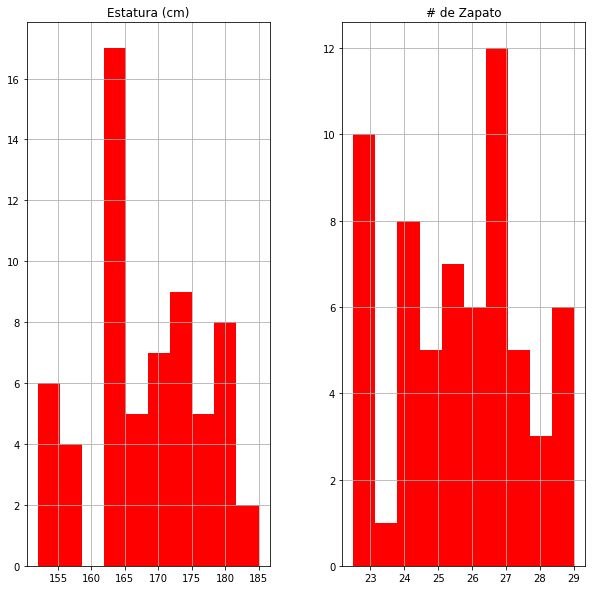

In [231]:
X[varc].hist(figsize=(10,10),color='red')

In [232]:
for v,li,ls in X[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like='ex_').max(axis=1)
X['ex_'].value_counts(1)

0    0.984127
1    0.015873
Name: ex_, dtype: float64

In [233]:
X[um+vart] = df[um+vart]

In [234]:
X = X.loc[X['ex_']==0].drop(X.filter(like='ex_').columns,axis=1).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'Estatura (cm)'}>,
        <AxesSubplot:title={'center':'# de Zapato'}>]], dtype=object)

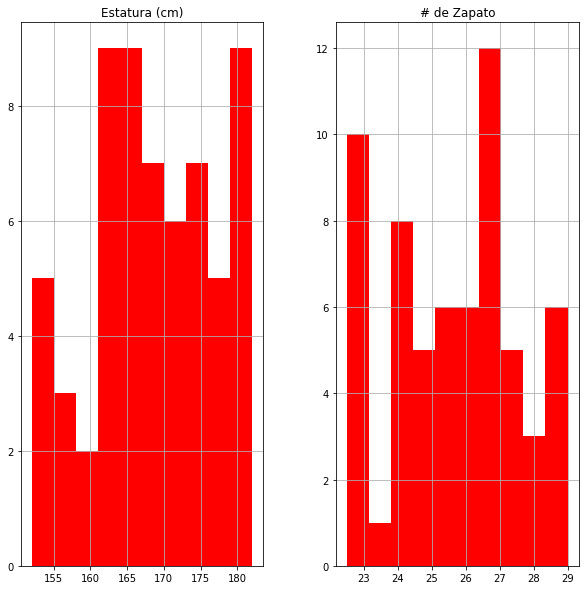

In [235]:
X[varc].hist(figsize=(10,10),color='red')

## Partición

In [236]:
Xt,Xv,yt,yv = train_test_split(X[um+varc],X[um+vart],train_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

## Aprendizaje

In [237]:
modelo = LinearDiscriminantAnalysis()
modelo.fit(Xt[varc],yt[vart[0]])

LinearDiscriminantAnalysis()

## Validación del modelo

In [238]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [239]:
St['y^'] = modelo.predict(Xt[varc])
Sv['y^'] = modelo.predict(Xv[varc])

St['proba'] = modelo.predict_proba(Xt[varc])[:,1]
Sv['proba'] = modelo.predict_proba(Xv[varc])[:,1]

In [240]:
print(accuracy_score(y_pred=St['y^'],y_true=St[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.8837209302325582
0.9473684210526315


In [241]:
print(roc_auc_score(y_true=St[vart[0]],y_score=St['proba']))
print(roc_auc_score(y_true=Sv[vart[0]],y_score=Sv['proba']))

0.9660633484162896
1.0


In [242]:
print(confusion_matrix(y_pred=St['y^'],y_true=St[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[23  3]
 [ 2 15]]
[[12  0]
 [ 1  6]]


In [243]:
df['pred'] = modelo.predict(df[varc])
df.head()

,id,Marca temporal,Edad (Años),Estatura (cm),Peso (Kg),# de Zapato,Sexo,pred
0,0,2022/02/15 6:31:48 p. m. GMT-6,21,163.0,65.0,24.5,Mujer,Mujer
1,1,2022/02/15 6:31:51 p. m. GMT-6,21,180.0,70.0,28.0,Hombre,Hombre
2,2,2022/02/15 6:31:55 p. m. GMT-6,22,180.0,80.0,28.5,Hombre,Hombre
3,3,2022/02/15 6:31:55 p. m. GMT-6,21,180.0,83.0,29.0,Hombre,Hombre
4,4,2022/02/15 6:31:56 p. m. GMT-6,23,178.0,67.0,27.5,Hombre,Hombre


In [244]:
df.loc[df['Sexo']!=df['pred']]

,id,Marca temporal,Edad (Años),Estatura (cm),Peso (Kg),# de Zapato,Sexo,pred
8,8,2022/02/15 6:31:59 p. m. GMT-6,22,165.0,65.0,25.0,Hombre,Mujer
24,24,2022/02/15 6:32:19 p. m. GMT-6,21,167.0,63.0,25.5,Mujer,Hombre
25,25,2022/02/15 6:32:21 p. m. GMT-6,22,165.0,71.0,25.5,Mujer,Hombre
48,48,2022/02/15 6:33:32 p. m. GMT-6,21,163.0,62.0,25.0,Hombre,Mujer
53,53,2022/02/15 6:33:52 p. m. GMT-6,21,158.0,56.0,25.0,Hombre,Mujer
54,54,2022/02/15 6:34:01 p. m. GMT-6,21,169.5,73.0,26.5,Mujer,Hombre
